In [1]:
from sys import platform
import sys, os
# identification de la base de prix utilisée : directory principal
# sur ubuntu

path=''
if platform == 'linux' :
    path ='/workspace/NeuralPricing/A_GeneralizedSABR/CallOption'
# sur. mac osx
if platform == 'darwin' :
    path ='/Users/olivier/keras/NeuralPricing/A_CLEWE_CAC'
import keras,tensorflow,pkg_resources
dataDirectory='Data'
dataLearningFile = "CLEWE_CAC.CSV"
#datafile='Data/Baby_Learningbase1.CSV'
os.chdir(path)
# le package identifie la methode de calibration : sous-directory

/Users/olivier/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from __future__ import print_function
import tensorflow as tf
from math import sqrt, exp, log, erf,floor
import numpy 
import pandas
from decimal import *
import keras
from keras.layers import Dense
from keras.layers import Dropout
from keras import regularizers
from keras import callbacks
from keras.layers import Activation
from keras.layers import Lambda
from keras.models import Sequential
from keras.models import model_from_json
import keras.layers
import matplotlib
import matplotlib.pyplot as pyplot
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import mpl_toolkits
from mpl_toolkits.mplot3d import axes3d
from mpl_toolkits.mplot3d.axes3d import Axes3D
from sklearn import preprocessing
from sklearn import model_selection
import joblib
import seaborn as sns
import scipy
from IPython.display import display
import time
%matplotlib inline
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual,FloatProgress
import ipywidgets as widgets
import math


In [3]:
getcontext().prec = 8

from util_functions_CLEWE_CAC import *

In [4]:
params=metaparameters()

params.INPUT_DIM  = 5
params.INPUT_VOL =5
params.NB_NEURON_PRINCIPAL =8
params.ACTIVATION_PRINCIPALE = 'tanh'
params.ACTIVATION_PRINCIPALE_FINALE = 'linear'
params.INITIAL_LEARNING_NB_EPOCH=1000
params.LEARNINGBASE_ORIGIN="New_Test"
params.LEARNINGBASE_BUT="New_Simu_Test"
params.GENETIC_LEARNING_NB_EPOCH = 10
params.BATCH_SIZE_PRINCIPAL = 32768
params.OPTIMIZER='adamax'
params.OPTIMIZER_GENETIC='SGD'
params.NBLAYERS = 11
params.NB_LOOPS = 5
params.PATH = path
params.VERBOSE_FLAG=2
params.EPSILON_GREEDINESS = 0.25
params.EPSILON_GREEDINESS_DECREASING_FACTOR = 0.99
params.INITIAL_NETWORK_STRUCTURE = [[0,10],[1,20],[2,30],[0,10]]

In [5]:
startTime = time.time()
dataframe = pandas.read_csv(dataDirectory+"/"+dataLearningFile)
endTime = time.time()
print('temps de lecture du ficher',endTime - startTime)
dataset = dataframe.values
X = dataset[:,1:params.INPUT_DIM+1]
datasize=dataset[1:,params.INPUT_DIM].size
X_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
X_scaled = (X_scaler.fit_transform(X))
Y_Vol = dataset[:,params.INPUT_VOL]
params.X_scaler = X_scaler
params.X_scaled = X_scaled
params.X = X
Y_scaler_Vol = preprocessing.MinMaxScaler(feature_range=(0, 1))
Y_scaled_Vol = (Y_scaler_Vol.fit_transform(Y_Vol.reshape(-1, 1))).reshape(1, -1)[0]
params.Y_scaler_Vol = Y_scaler_Vol
params.Y_scaled_Vol = Y_scaled_Vol
params.Y_Vol = Y_Vol

temps de lecture du ficher 0.010791778564453125


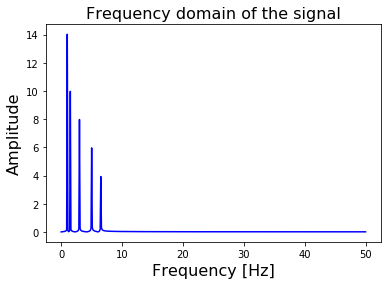

In [6]:
from scipy.fftpack import fft
 
def get_fft_values(y_values, T, N, f_s):
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    return f_values, fft_values
 
t_n = 10
N = 1000
T = t_n / N
f_s = 1/T
 
x_value = np.linspace(0,t_n,N)
amplitudes = [4, 6, 8, 10, 14]
frequencies = [6.5, 5, 3, 1.5, 1]
y_values = [amplitudes[ii]*np.sin(2*np.pi*frequencies[ii]*x_value) for ii in range(0,len(amplitudes))]
composite_y_value = np.sum(y_values, axis=0)

f_values, fft_values = get_fft_values(composite_y_value, T, N, f_s)
 
pyplot.plot(f_values, fft_values, linestyle='-', color='blue')
pyplot.xlabel('Frequency [Hz]', fontsize=16)
pyplot.ylabel('Amplitude', fontsize=16)
pyplot.title("Frequency domain of the signal", fontsize=16)
pyplot.show()

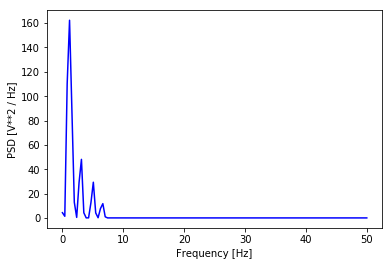

In [9]:
from scipy.signal import welch
 
def get_psd_values(y_values, T, N, f_s):
    f_values, psd_values = welch(y_values, fs=f_s)
    return f_values, psd_values
 
t_n = 10
N = 1000
T = t_n / N
f_s = 1/T

x_value = np.linspace(0,t_n,N)
amplitudes = [4, 6, 8, 10, 14]
frequencies = [6.5, 5, 3, 1.5, 1]
y_values = [amplitudes[ii]*np.sin(2*np.pi*frequencies[ii]*x_value) for ii in range(0,len(amplitudes))]
composite_y_value = np.sum(y_values, axis=0)
    
f_values, psd_values = get_psd_values(composite_y_value, T, N, f_s)
 
pyplot.plot(f_values, psd_values, linestyle='-', color='blue')
pyplot.xlabel('Frequency [Hz]')
pyplot.ylabel('PSD [V**2 / Hz]')
pyplot.show()

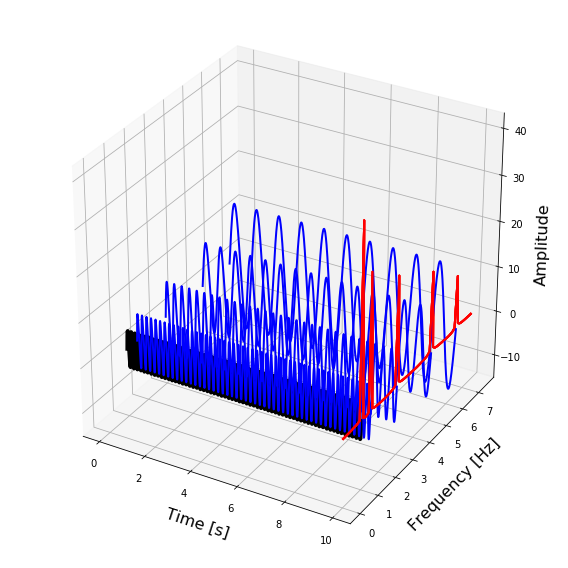

In [12]:
from mpl_toolkits.mplot3d import Axes3D

t_n = 10
N = 1000
T = t_n / N
f_s = 1/T

x_value = np.linspace(0,t_n,N)
amplitudes = [4, 6, 8, 10, 14]
frequencies = [6.5, 5, 3, 1.5, 1]
y_values_ = [amplitudes[ii]*np.sin(2*np.pi*frequencies[ii]*x_value) for ii in range(0,len(amplitudes))]
composite_y_value = np.sum(y_values, axis=0)

f_values, fft_values = get_fft_values(composite_y_value, T, N, f_s)

colors = ['k', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b']

fig = pyplot.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("\nTime [s]", fontsize=16)
ax.set_ylabel("\nFrequency [Hz]", fontsize=16)
ax.set_zlabel("\nAmplitude", fontsize=16)

##y_values_ = [composite_y_value] + list(reversed(y_values))
frequencies = [1, 1.5, 3, 5, 6.5]

for ii in range(0,len(y_values)):
    signal = y_values_[ii]
    color = colors[ii]
    length = signal.shape[0]
    x=np.linspace(0,10,1000)
    y=np.array([frequencies[ii]]*length)
    z=signal

    if ii == 0:
        linewidth = 4
    else:
        linewidth = 2
    ax.plot(list(x), list(y), zs=list(z), linewidth=linewidth, color=color)

    x=[10]*75
    y=f_values[:75]
    z = fft_values[:75]*3
    ax.plot(list(x), list(y), zs=list(z), linewidth=2, color='red')
    
    pyplot.tight_layout()
pyplot.show()

In [22]:
import pywt
print(pywt.families(short=False))

['Haar', 'Daubechies', 'Symlets', 'Coiflets', 'Biorthogonal', 'Reverse biorthogonal', 'Discrete Meyer (FIR Approximation)', 'Gaussian', 'Mexican hat wavelet', 'Morlet wavelet', 'Complex Gaussian wavelets', 'Shannon wavelets', 'Frequency B-Spline wavelets', 'Complex Morlet wavelets']


/Users/olivier/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  import sys


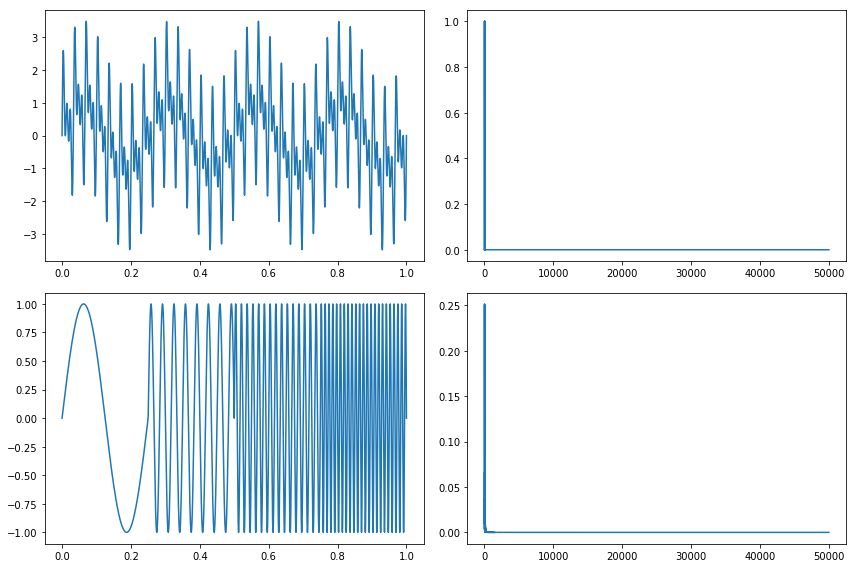

In [16]:
import pywt
print(pywt.families(short=False))
t_n = 1
N = 100000
T = t_n / N
f_s = 1/T
 
xa = np.linspace(0, t_n, num=N)
xb = np.linspace(0, t_n/4, num=N/4)
 
frequencies = [4, 30, 60, 90]
y1a, y1b = np.sin(2*np.pi*frequencies[0]*xa), np.sin(2*np.pi*frequencies[0]*xb)
y2a, y2b = np.sin(2*np.pi*frequencies[1]*xa), np.sin(2*np.pi*frequencies[1]*xb)
y3a, y3b = np.sin(2*np.pi*frequencies[2]*xa), np.sin(2*np.pi*frequencies[2]*xb)
y4a, y4b = np.sin(2*np.pi*frequencies[3]*xa), np.sin(2*np.pi*frequencies[3]*xb)
 
composite_signal1 = y1a + y2a + y3a + y4a
composite_signal2 = np.concatenate([y1b, y2b, y3b, y4b])
 
f_values1, fft_values1 = get_fft_values(composite_signal1, T, N, f_s)
f_values2, fft_values2 = get_fft_values(composite_signal2, T, N, f_s)
 
fig, axarr = pyplot.subplots(nrows=2, ncols=2, figsize=(12,8))
axarr[0,0].plot(xa, composite_signal1)
axarr[1,0].plot(xa, composite_signal2)
axarr[0,1].plot(f_values1, fft_values1)
axarr[1,1].plot(f_values2, fft_values2)
(...)
pyplot.tight_layout()
pyplot.show()

/Users/olivier/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


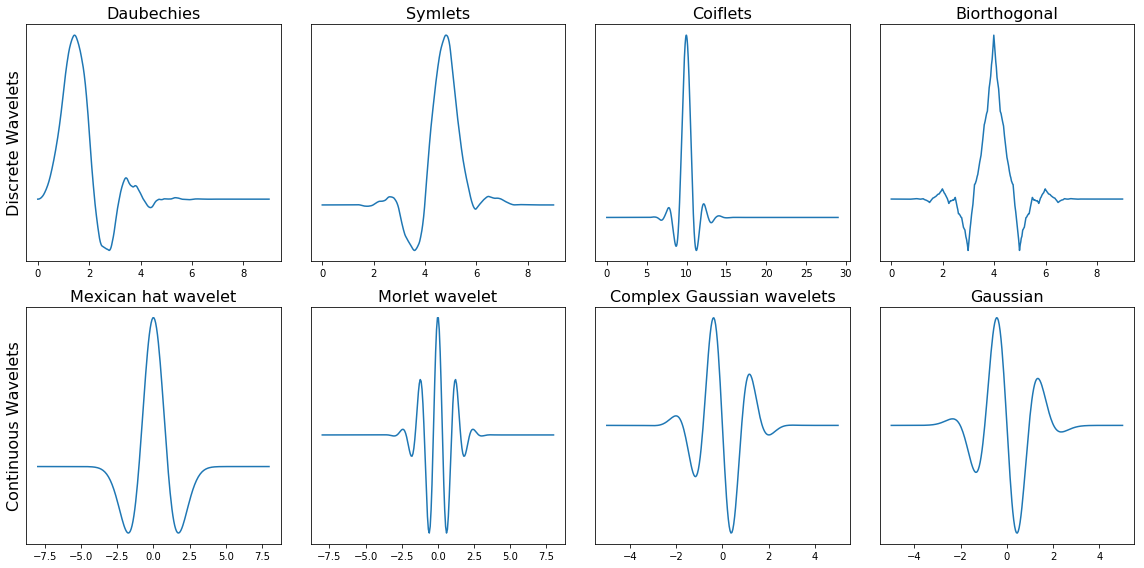

In [25]:
discrete_wavelets = ['db5', 'sym5', 'coif5', 'bior2.4']
continuous_wavelets = ['mexh', 'morl', 'cgau5', 'gaus5']
 
list_list_wavelets = [discrete_wavelets, continuous_wavelets]
list_funcs = [pywt.Wavelet, pywt.ContinuousWavelet]
 
fig, axarr = pyplot.subplots(nrows=2, ncols=4, figsize=(16,8))
for ii, list_wavelets in enumerate(list_list_wavelets):
    func = list_funcs[ii]
    row_no = ii
    for col_no, waveletname in enumerate(list_wavelets):
        wavelet = func(waveletname)
        family_name = wavelet.family_name
        biorthogonal = wavelet.biorthogonal
        orthogonal = wavelet.orthogonal
        symmetry = wavelet.symmetry
        if ii == 0:
            _ = wavelet.wavefun()
            wavelet_function = _[0]
            x_values = _[-1]
        else:
            wavelet_function, x_values = wavelet.wavefun()
        if col_no == 0 and ii == 0:
            axarr[row_no, col_no].set_ylabel("Discrete Wavelets", fontsize=16)
        if col_no == 0 and ii == 1:
            axarr[row_no, col_no].set_ylabel("Continuous Wavelets", fontsize=16)
        axarr[row_no, col_no].set_title("{}".format(family_name), fontsize=16)
        axarr[row_no, col_no].plot(x_values, wavelet_function)
        axarr[row_no, col_no].set_yticks([])
        axarr[row_no, col_no].set_yticklabels([])
pyplot.tight_layout()
pyplot.show()

['db1', 'db2', 'db3', 'db4', 'db5']


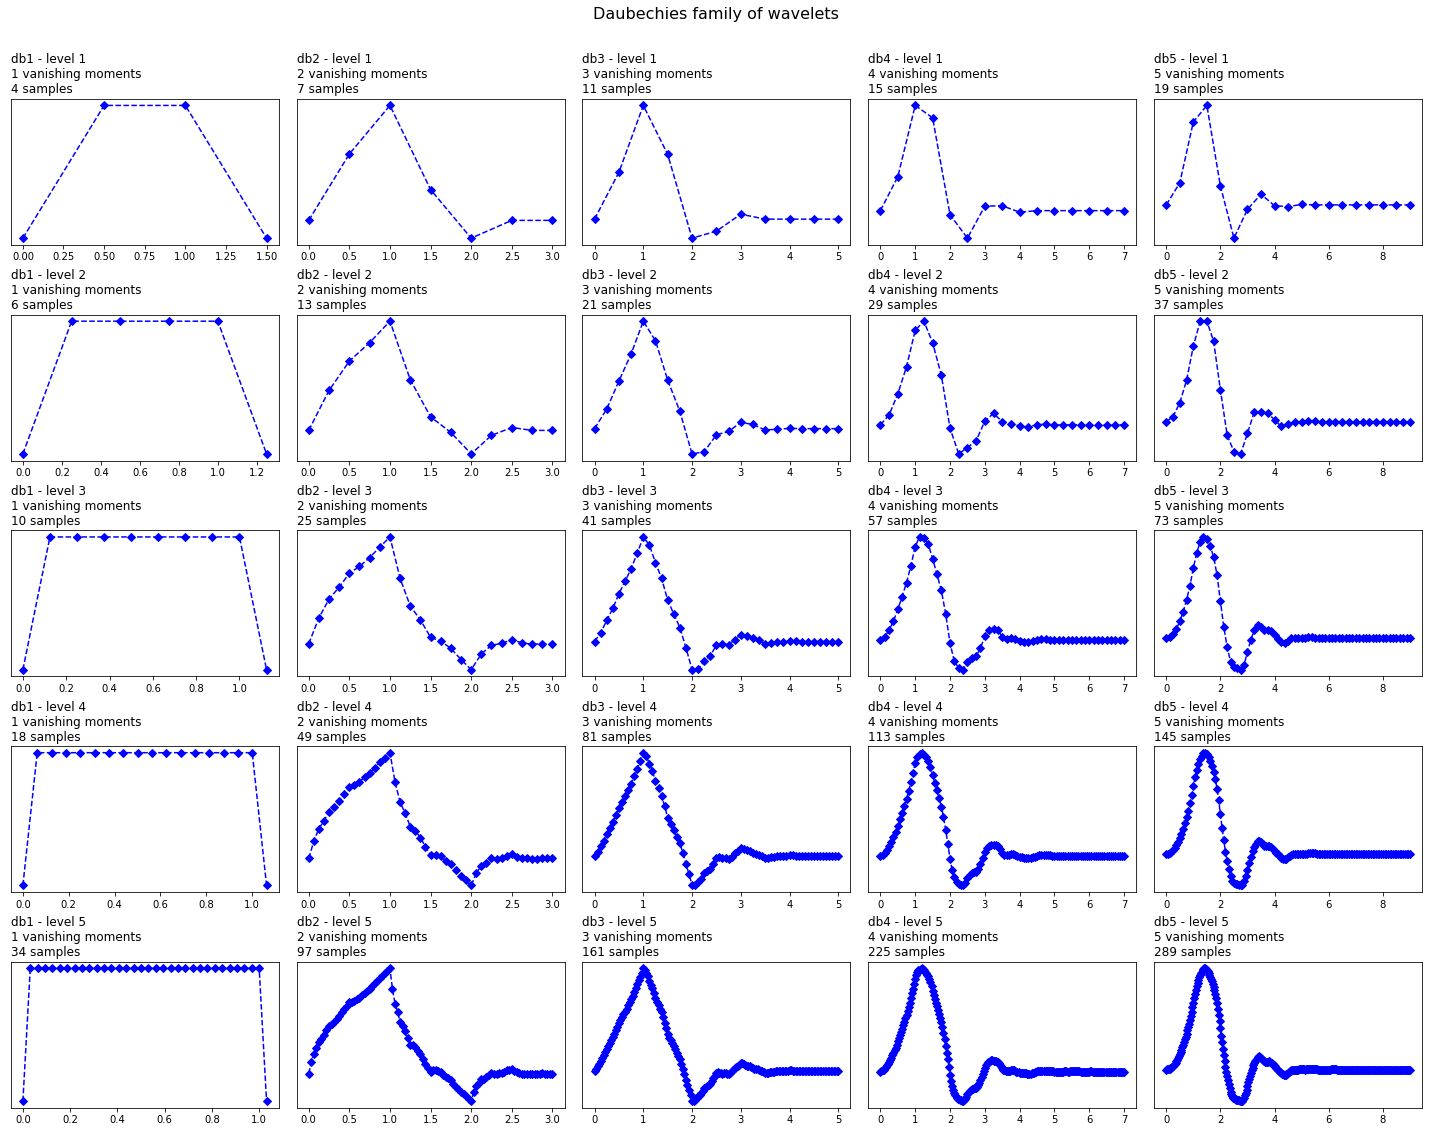

In [27]:
import matplotlib.pyplot as plt
 
db_wavelets = pywt.wavelist('db')[:5]
print(db_wavelets)

 
fig, axarr = plt.subplots(ncols=5, nrows=5, figsize=(20,16))
fig.suptitle('Daubechies family of wavelets', fontsize=16)
for col_no, waveletname in enumerate(db_wavelets):
    wavelet = pywt.Wavelet(waveletname)
    no_moments = wavelet.vanishing_moments_psi
    family_name = wavelet.family_name
    for row_no, level in enumerate(range(1,6)):
        wavelet_function, scaling_function, x_values = wavelet.wavefun(level = level)
        axarr[row_no, col_no].set_title("{} - level {}\n{} vanishing moments\n{} samples".format(
            waveletname, level, no_moments, len(x_values)), loc='left')
        axarr[row_no, col_no].plot(x_values, wavelet_function, 'bD--')
        axarr[row_no, col_no].set_yticks([])
        axarr[row_no, col_no].set_yticklabels([])
pyplot.tight_layout()
pyplot.subplots_adjust(top=0.9)
pyplot.show()

In [48]:
df_nino.shape

(503, 1)

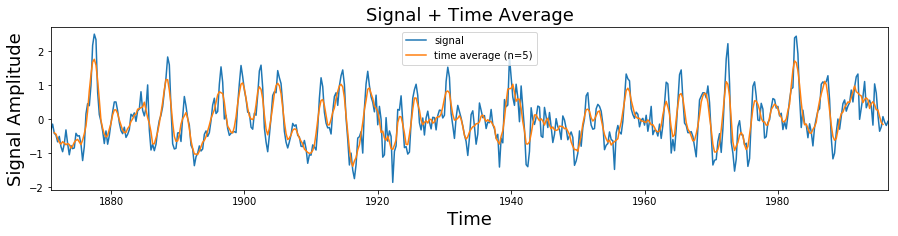

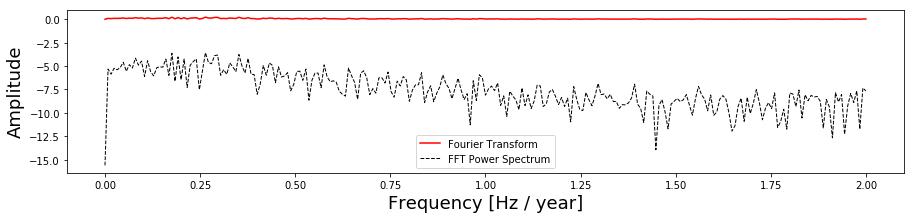

NameError: name 'pywt' is not defined

In [15]:
import matplotlib.pyplot as plt 
def plot_wavelet(time, signal, scales, 
                 waveletname = 'cmor', 
                 cmap = plt.cm.seismic, 
                 title = 'Wavelet Transform (Power Spectrum) of signal', 
                 ylabel = 'Period (years)', 
                 xlabel = 'Time'):
    
    dt = time[1] - time[0]
    [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname, dt)
    power = (abs(coefficients)) ** 2
    period = 1. / frequencies
    levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
    contourlevels = np.log2(levels)
    
    fig, ax = plt.subplots(figsize=(15, 10))
    im = ax.contourf(time, np.log2(period), np.log2(power), contourlevels, extend='both',cmap=cmap)
    
    ax.set_title(title, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=18)
    
    yticks = 2**np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(period.max())))
    ax.set_yticks(np.log2(yticks))
    ax.set_yticklabels(yticks)
    ax.invert_yaxis()
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], -1)
    
    cbar_ax = fig.add_axes([0.95, 0.5, 0.03, 0.25])
    fig.colorbar(im, cax=cbar_ax, orientation="vertical")
    plt.show()
    
def get_average_values(time, signal, average_over):
    time_ave = np.zeros(len(time)-average_over)
    signal_ave = np.zeros(len(signal)-average_over)
    for ii in range(len(time_ave)):
        time_ave[ii]=np.mean(time[ii:ii+average_over])
    for ii in range(len(signal_ave)):
        signal_ave[ii]=np.mean(signal[ii:ii+average_over])    
    return time_ave, signal_ave 

def plot_signal_plus_average(time, signal, average_over = 5):
    fig, ax = plt.subplots(figsize=(15, 3))
    time_ave, signal_ave = get_average_values(time, signal, average_over)
    ax.plot(time, signal, label='signal')
    ax.plot(time_ave, signal_ave, label = 'time average (n={})'.format(5))
    ax.set_xlim([time[0], time[-1]])
    ax.set_ylabel('Signal Amplitude', fontsize=18)
    ax.set_title('Signal + Time Average', fontsize=18)
    ax.set_xlabel('Time', fontsize=18)
    ax.legend()
    plt.show()
    
def get_fft_values(y_values, T, N, f_s):
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    return f_values, fft_values
 
def plot_fft_plus_power(time, signal):
    dt = time[1] - time[0]
    N = len(signal)
    fs = 1/dt
    
    fig, ax = plt.subplots(figsize=(15, 3))
    variance = np.std(signal)**2
    f_values, fft_values = get_fft_values(signal, dt, N, fs)
    fft_power = variance * abs(fft_values) ** 2     # FFT power spectrum
    ax.plot(f_values, fft_values, 'r-', label='Fourier Transform')
    ax.plot(f_values, fft_power, 'k--', linewidth=1, label='FFT Power Spectrum')
    ax.set_xlabel('Frequency [Hz / year]', fontsize=18)
    ax.set_ylabel('Amplitude', fontsize=18)
    ax.legend()
    print('fft_power=',fft_power)
    plt.show()

def plot_fft_plus_log_power(time, signal):
    dt = time[1] - time[0]
    N = len(signal)
    fs = 1/dt
    
    fig, ax = plt.subplots(figsize=(15, 3))
    variance = np.std(signal)**2
    f_values, fft_values = get_fft_values(signal, dt, N, fs)
    fft_power = variance * abs(fft_values) ** 2     # FFT power spectrum
    fft_power1 = np.zeros(len(fft_power))
    for ii in range(len(fft_power)):
        fft_power1[ii]=log(fft_power[ii])
    ax.plot(f_values, fft_values, 'r-', label='Fourier Transform')
    ax.plot(f_values, fft_power1, 'k--', linewidth=1, label='FFT Power Spectrum')
    ax.set_xlabel('Frequency [Hz / year]', fontsize=18)
    ax.set_ylabel('Amplitude', fontsize=18)
    ax.legend()
    plt.show()
    
dataset = "http://paos.colorado.edu/research/wavelets/wave_idl/sst_nino3.dat"
df_nino = pandas.read_table(dataset)
N = df_nino.shape[0]
t0=1871
dt=0.25
time = np.arange(0, N) * dt + t0
signal = df_nino.values.squeeze()
 
scales = np.arange(1, 512)
plot_signal_plus_average(time, signal)
plot_fft_plus_log_power(time, signal)
plot_wavelet(time, signal, scales)

In [62]:
Y_Vol.shape[0]

844

In [61]:
signal.shape

(503,)

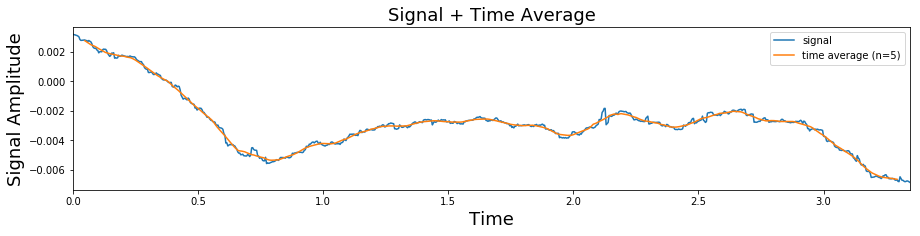

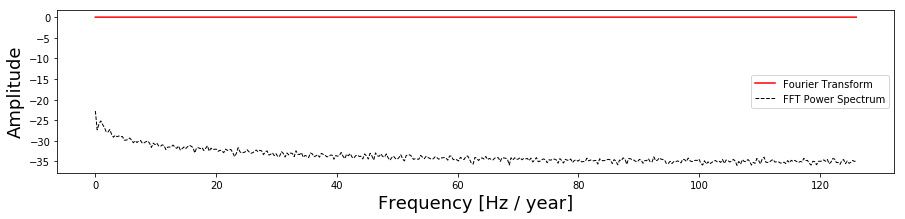

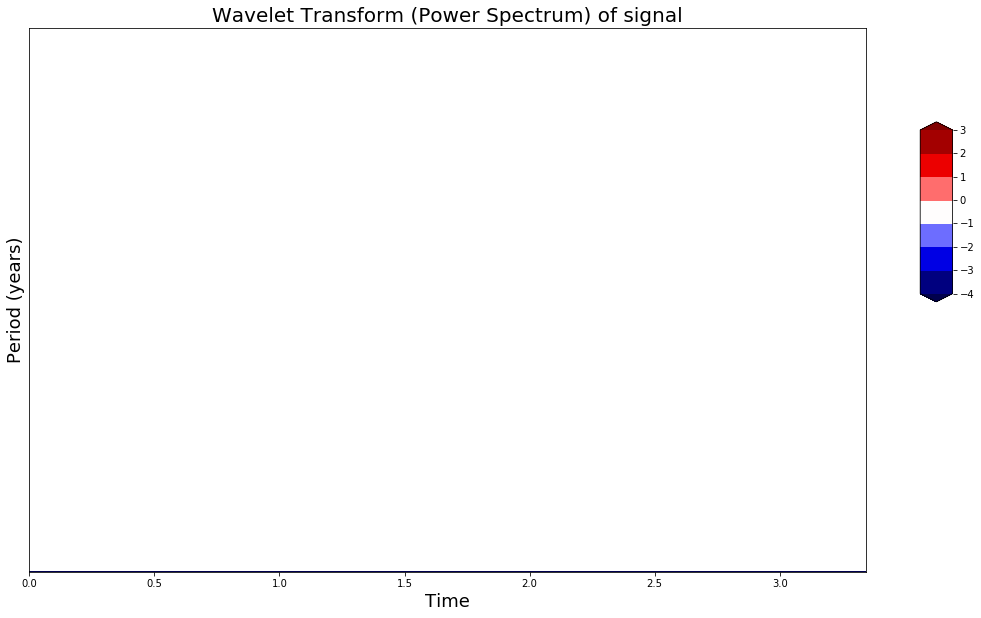

In [90]:
N = Y_Vol.shape[0]
t0=0
dt=1/252
time1 = np.arange(0, N) * dt + t0
signal1 = Y_Vol.squeeze()
signal1 = Y_Vol
scales = np.arange(1, 50)
plot_signal_plus_average(time1, signal1,average_over = 25)
plot_fft_plus_log_power(time1, signal1)
plot_wavelet(time1, signal1, scales,ylabel = 'Period (years)',  xlabel = 'Time')

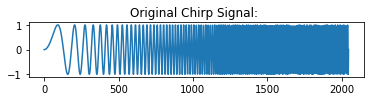

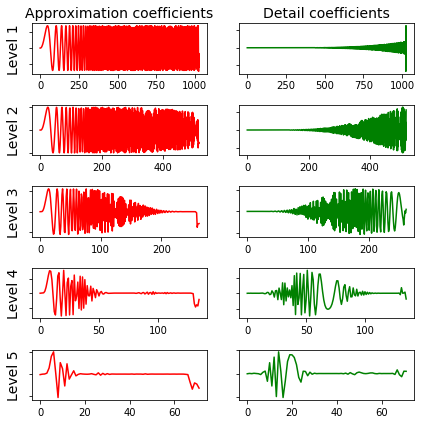

In [44]:
import pywt
 
x = np.linspace(0, 1, num=2048)
chirp_signal = np.sin(250 * np.pi * x**2)
    
fig, ax = plt.subplots(figsize=(6,1))
ax.set_title("Original Chirp Signal: ")
ax.plot(chirp_signal)
plt.show()
    
data = chirp_signal
waveletname = 'sym5'
 
fig, axarr = plt.subplots(nrows=5, ncols=2, figsize=(6,6))
for ii in range(5):
    (data, coeff_d) = pywt.dwt(data, waveletname)
    axarr[ii, 0].plot(data, 'r')
    axarr[ii, 1].plot(coeff_d, 'g')
    axarr[ii, 0].set_ylabel("Level {}".format(ii + 1), fontsize=14, rotation=90)
    axarr[ii, 0].set_yticklabels([])
    if ii == 0:
        axarr[ii, 0].set_title("Approximation coefficients", fontsize=14)
        axarr[ii, 1].set_title("Detail coefficients", fontsize=14)
    axarr[ii, 1].set_yticklabels([])
plt.tight_layout()
plt.show()

In [16]:
def read_signals_ucihar(filename):
    with open(filename, 'r') as fp:
        data = fp.read().splitlines()
        data = map(lambda x: x.rstrip().lstrip().split(), data)
        data = [list(map(float, line)) for line in data]
    return data
 
def read_labels_ucihar(filename):        
    with open(filename, 'r') as fp:
        activities = fp.read().splitlines()
        activities = list(map(int, activities))
    return activities
 
def load_ucihar_data(folder):
    train_folder = folder + 'train/InertialSignals/'
    test_folder = folder + 'test/InertialSignals/'
    labelfile_train = folder + 'train/y_train.txt'
    labelfile_test = folder + 'test/y_test.txt'
    train_signals, test_signals = [], []
    for input_file in os.listdir(train_folder):
        signal = read_signals_ucihar(train_folder + input_file)
        train_signals.append(signal)
    train_signals = np.transpose(np.array(train_signals), (1, 2, 0))
    for input_file in os.listdir(test_folder):
        signal = read_signals_ucihar(test_folder + input_file)
        test_signals.append(signal)
    test_signals = np.transpose(np.array(test_signals), (1, 2, 0))
    train_labels = read_labels_ucihar(labelfile_train)
    test_labels = read_labels_ucihar(labelfile_test)
    return train_signals, train_labels, test_signals, test_labels
folder_ucihar = '/Users/olivier/keras/NeuralPricing/A_CLEWE_CAC/Data/UCI HAR/'
uci_har_signals_train, uci_har_labels_train, uci_har_signals_test, uci_har_labels_test = load_ucihar_data(folder_ucihar)

In [17]:
import pywt

waveletname = 'morl'
train_size = 5000
test_size= 500
 
train_data_cwt = np.ndarray(shape=(train_size, 127, 127, 9))
 
for ii in range(0,train_size):
    if ii % 1000 == 0:
        print(ii)
    for jj in range(0,9):
        signal = uci_har_signals_train[ii, :, jj]
        coeff, freq = pywt.cwt(signal, scales, waveletname, 1)
        coeff_ = coeff[:,:127]
        train_data_cwt[ii, :, :, jj] = coeff_

test_data_cwt = np.ndarray(shape=(test_size, 127, 127, 9))
for ii in range(0,test_size):
    if ii % 100 == 0:
        print(ii)
    for jj in range(0,9):
        signal = uci_har_signals_test[ii, :, jj]
        coeff, freq = pywt.cwt(signal, scales, waveletname, 1)
        coeff_ = coeff[:,:127]
        test_data_cwt[ii, :, :, jj] = coeff_

uci_har_labels_train = list(map(lambda x: int(x) - 1, uci_har_labels_train))
uci_har_labels_test = list(map(lambda x: int(x) - 1, uci_har_labels_test))
 
x_train = train_data_cwt
y_train = list(uci_har_labels_train[:train_size])
x_test = test_data_cwt
y_test = list(uci_har_labels_test[:test_size])

0


NameError: name 'pywt' is not defined

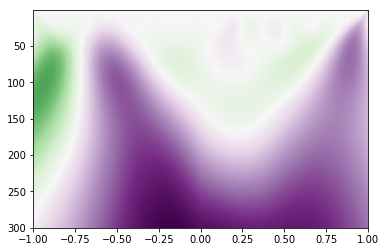

In [18]:
from scipy import signal
import matplotlib.pyplot as plt
t = np.linspace(-1, 1, 300, endpoint=False)
sig = Y_Vol
widths = np.arange(1, 300)
cwtmatr = signal.cwt(sig, signal.ricker, widths)
plt.imshow(cwtmatr, extent=[-1, 1, 300, 1], cmap='PRGn', aspect='auto',vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
plt.show()



/Users/olivier/anaconda3/lib/python3.6/site-packages/pywt/_multilevel.py:148: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  a = a[[slice(s) for s in d.shape]]


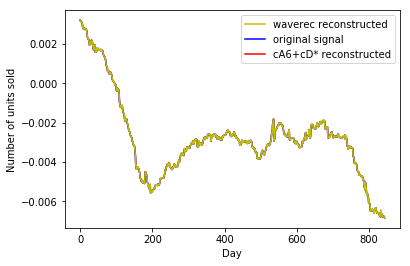

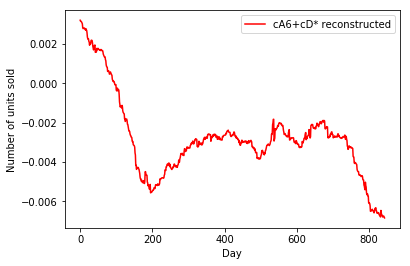

In [19]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

data = sig
n = len(data)
wl = pywt.Wavelet("db1")
coeff_all = pywt.wavedec(data, wl, level=6)
cA6, cD6,cD5, cD4, cD3, cD2, cD1= coeff_all
omp0 = pywt.upcoef('a',cA6,wl,level=6)[:n]
omp1 = pywt.upcoef('d',cD1,wl,level=1)[:n]
omp2 = pywt.upcoef('d',cD2,wl,level=2)[:n]
omp3 = pywt.upcoef('d',cD3,wl,level=3)[:n]
omp4 = pywt.upcoef('d',cD4,wl,level=4)[:n]
omp5 = pywt.upcoef('d',cD5,wl,level=5)[:n]
omp6 = pywt.upcoef('d',cD6,wl,level=6)[:n]

#cA6cD_approx = omp0 + omp1 + omp2 + omp3 + omp4+ omp5 + omp6
#plt.figure(figsize=(18,9))
recon = pywt.waverec(coeff_all, wavelet= wl)
p1, =plt.plot(omp0 + omp6 + omp5 + omp4 + omp3 + omp2 + omp1,'r')
p2, =plt.plot(data, 'b')
p3, =plt.plot(recon, 'y')

plt.xlabel('Day')
plt.ylabel('Number of units sold')
plt.legend([p3,p2,p1], ["waverec reconstructed","original signal", "cA6+cD* reconstructed"])
plt.show()

p1, =plt.plot(omp0 + omp6 + omp5 + omp4 + omp3 + omp2 + omp1,'r')
plt.xlabel('Day')
plt.ylabel('Number of units sold')
plt.legend([p1], [ "cA6+cD* reconstructed"])
plt.show()

In [123]:
[cD1.shape,cD2.shape,cD3.shape,cD4.shape,cD5.shape,cD6.shape]

[(422,), (211,), (106,), (53,), (27,), (14,)]

/Users/olivier/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  import sys


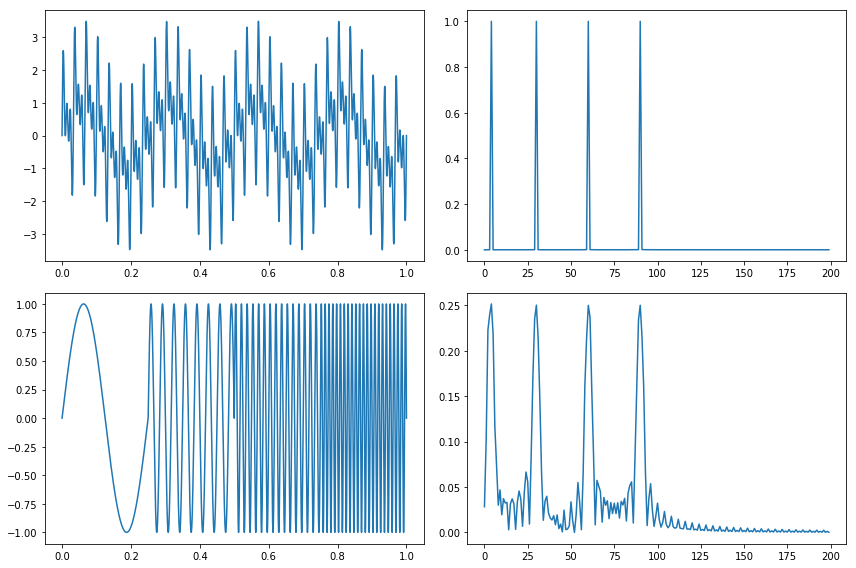

In [159]:
t_n = 1
N = 100000
T = t_n / N
f_s = 1/T
 
xa = np.linspace(0, t_n, num=N)
xb = np.linspace(0, t_n/4, num=N/4)
 
frequencies = [4, 30, 60, 90]
y1a = np.sin(2*np.pi*frequencies[0]*xa)
y1b = np.sin(2*np.pi*frequencies[0]*xb)
y2a= np.sin(2*np.pi*frequencies[1]*xa)
y2b  = np.sin(2*np.pi*frequencies[1]*xb)
y3a = np.sin(2*np.pi*frequencies[2]*xa)
y3b = np.sin(2*np.pi*frequencies[2]*xb)
y4a= np.sin(2*np.pi*frequencies[3]*xa)
y4b  = np.sin(2*np.pi*frequencies[3]*xb)
 
composite_signal1 = y1a + y2a + y3a + y4a
composite_signal2 = np.concatenate([y1b, y2b, y3b, y4b])
 
f_values1, fft_values1 = get_fft_values(composite_signal1, T, N, f_s)
f_values2, fft_values2 = get_fft_values(composite_signal2, T, N, f_s)
N2=floor(N/2)

fig, axarr = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
axarr[0,0].plot(xa, composite_signal1)
axarr[1,0].plot(xa, composite_signal2)
axarr[0,1].plot(f_values1[0:200], fft_values1[0:200])
axarr[1,1].plot(f_values2[0:200], fft_values2[0:200])
plt.tight_layout()
plt.show()

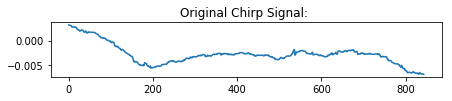

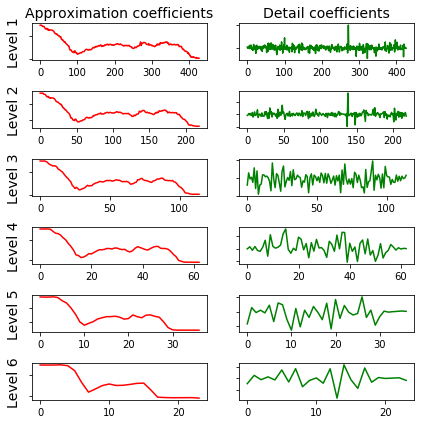

In [177]:
x = np.linspace(0, 1, num=2048)
chirp_signal = np.sin(250 * np.pi * x**2)
chirp_signal = Y_Vol
    
fig, ax = plt.subplots(figsize=(7,1))
ax.set_title("Original Chirp Signal: ")
ax.plot(chirp_signal)
plt.show()
    
data = chirp_signal
waveletname = 'sym6'
 
fig, axarr = plt.subplots(nrows=6, ncols=2, figsize=(6,6))
for ii in range(6):
    (data, coeff_d) = pywt.dwt(data, waveletname)
    axarr[ii, 0].plot(data, 'r')
    axarr[ii, 1].plot(coeff_d, 'g')
    axarr[ii, 0].set_ylabel("Level {}".format(ii + 1), fontsize=14, rotation=90)
    axarr[ii, 0].set_yticklabels([])
    if ii == 0:
        axarr[ii, 0].set_title("Approximation coefficients", fontsize=14)
        axarr[ii, 1].set_title("Detail coefficients", fontsize=14)
    axarr[ii, 1].set_yticklabels([])
plt.tight_layout()
plt.show()

In [24]:
signal.shape

(844,)

/Users/olivier/anaconda3/lib/python3.6/site-packages/pywt/_multilevel.py:148: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  a = a[[slice(s) for s in d.shape]]


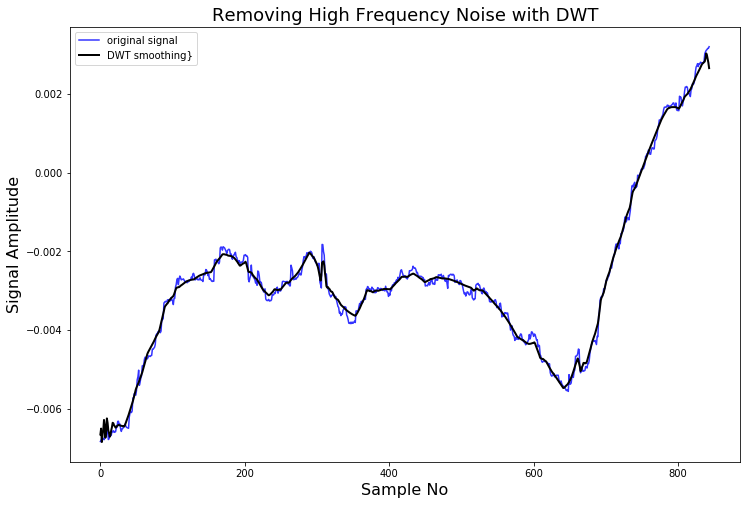

In [27]:
signal = Y_Vol[::-1]
 
def lowpassfilter(signal, thresh = 0.1, wavelet="db3"):
    thresh = thresh*np.nanmax(signal)
    coeff = pywt.wavedec(signal, wavelet, mode="per" )
    coeff[1:] = (pywt.threshold(i, value=thresh, mode="soft" ) for i in coeff[1:])
    reconstructed_signal = pywt.waverec(coeff, wavelet, mode="per" )
    return reconstructed_signal
 
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(signal[0:844], color="b", alpha=0.8, label='original signal')
rec = lowpassfilter(signal, 0.1)
ax.plot(rec[0:844], 'k', label='DWT smoothing}', linewidth=2)
ax.legend()
ax.set_title('Removing High Frequency Noise with DWT', fontsize=18)
ax.set_ylabel('Signal Amplitude', fontsize=16)
ax.set_xlabel('Sample No', fontsize=16)
plt.show()

 

/Users/olivier/anaconda3/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


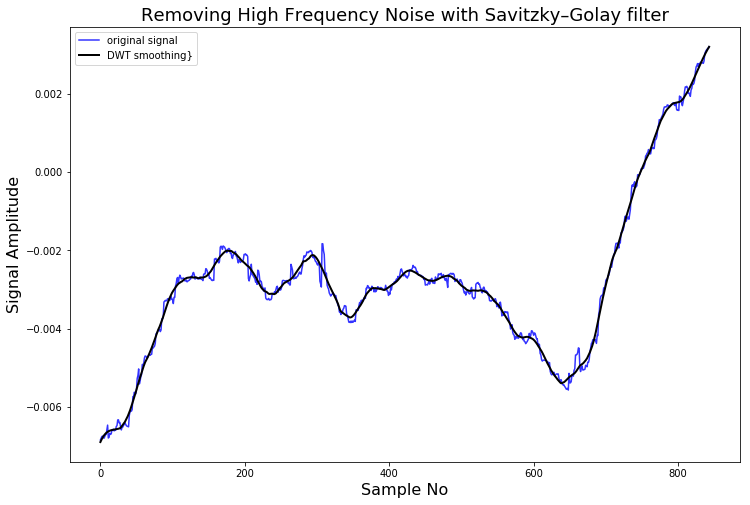

In [31]:
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1)

x = np.linspace(0,2*np.pi,100)
y = np.sin(x) + np.random.random(100) * 0.2

y = Y_Vol[::-1]
x = range(len(y))
yhat = scipy.signal.savgol_filter(y, 51, 3) # window size 51, polynomial order 3

fig, ax = plt.subplots(figsize=(12,8))
#plt.plot(x[0:844],y[0:844])
#plt.plot(x[0:844],yhat[0:844], color='red')

ax.plot(signal[0:844], color="b", alpha=0.8, label='original signal')

ax.plot(yhat[0:844], 'k', label='DWT smoothing}', linewidth=2)
ax.legend()
ax.set_title('Removing High Frequency Noise with Savitzky–Golay filter', fontsize=18)
ax.set_ylabel('Signal Amplitude', fontsize=16)
ax.set_xlabel('Sample No', fontsize=16)
plt.show()

In [190]:
###x = np.array(self.stock_data.iloc[i: i + 11, j])  
x =Y_Vol
(ca, cd) = pywt.dwt(x, "haar")                
cat = pywt.threshold(ca, np.std(ca), mode="soft")                
cdt = pywt.threshold(cd, np.std(cd), mode="soft")                
tx = pywt.idwt(cat, cdt, "haar")

In [191]:
class AutoEncoder:
    def __init__(self, encoding_dim):
        self.encoding_dim = encoding_dim

    def build_train_model(self, input_shape, encoded1_shape, encoded2_shape, decoded1_shape, decoded2_shape):
        input_data = Input(shape=(1, input_shape))

        encoded1 = Dense(encoded1_shape, activation="relu", activity_regularizer=regularizers.l2(0))(input_data)
        encoded2 = Dense(encoded2_shape, activation="relu", activity_regularizer=regularizers.l2(0))(encoded1)
        encoded3 = Dense(self.encoding_dim, activation="relu", activity_regularizer=regularizers.l2(0))(encoded2)
        decoded1 = Dense(decoded1_shape, activation="relu", activity_regularizer=regularizers.l2(0))(encoded3)
        decoded2 = Dense(decoded2_shape, activation="relu", activity_regularizer=regularizers.l2(0))(decoded1)
        decoded = Dense(input_shape, activation="sigmoid", activity_regularizer=regularizers.l2(0))(decoded2)

        autoencoder = Model(inputs=input_data, outputs=decoded)

        encoder = Model(input_data, encoded3)

        # Now train the model using data we already preprocessed
        autoencoder.compile(loss="mean_squared_error", optimizer="adam")

        train = pd.read_csv("preprocessing/rbm_train.csv", index_col=0)
        ntrain = np.array(train)
        train_data = np.reshape(ntrain, (len(ntrain), 1, input_shape))

        # print(train_data)
        # autoencoder.summary()
        autoencoder.fit(train_data, train_data, epochs=1000)

In [195]:
import keras as kl
class NeuralNetwork:
    def __init__(self, input_shape, stock_or_return):
        self.input_shape = input_shape
        self.stock_or_return = stock_or_return

    def make_train_model(self):
        input_data = kl.Input(shape=(1, self.input_shape))
        lstm = kl.LSTM(5, input_shape=(1, self.input_shape), return_sequences=True, activity_regularizer=regularizers.l2(0.003),
                       recurrent_regularizer=regularizers.l2(0), dropout=0.2, recurrent_dropout=0.2)(input_data)
        perc = kl.Dense(5, activation="sigmoid", activity_regularizer=regularizers.l2(0.005))(lstm)
        lstm2 = kl.LSTM(2, activity_regularizer=regularizers.l2(0.01), recurrent_regularizer=regularizers.l2(0.001),
                        dropout=0.2, recurrent_dropout=0.2)(perc)
        out = kl.Dense(1, activation="sigmoid", activity_regularizer=regularizers.l2(0.001))(lstm2)

        model = Model(input_data, out)
        model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mse"])

        # load data

        train = np.reshape(np.array(pd.read_csv("features/autoencoded_train_data.csv", index_col=0)),
                           (len(np.array(pd.read_csv("features/autoencoded_train_data.csv"))), 1, self.input_shape))
        train_y = np.array(pd.read_csv("features/autoencoded_train_y.csv", index_col=0))
        # train_stock = np.array(pd.read_csv("train_stock.csv"))

        # train model

        model.fit(train, train_y, epochs=2000)

In [196]:
a =NeuralNetwork(Y_Vol.shape,Y_Vol)

In [197]:
a.make_train_model()

W0717 14:39:04.759790 4551771584 deprecation_wrapper.py:119] From /Users/olivier/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0717 14:39:04.827878 4551771584 deprecation_wrapper.py:119] From /Users/olivier/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



TypeError: Error converting shape to a TensorShape: int() argument must be a string, a bytes-like object or a number, not 'tuple'.